In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt

In [48]:
drugs_having_target = pd.read_csv(r"C:\PhD\2024\Data\Drugcomb\Drugcomb_Drug_target_DrugbankID_Uniprot\drugtarget_dual_cbd.csv")
drug_info = pd.read_csv(r"C:\PhD\2024\Data\Drugcomb\Drugcomb_completing_DrugbankID\Drugs_fill_na.csv")
summ = pd.read_csv(r"C:\PhD\2024\Data\Drugcomb\DrugComb_Summary_ReadyTo_Preprocessing.csv", low_memory=False)
drugcomb_cells = pd.read_csv(r"C:\PhD\2024\Data\Drugcomb\Cell_line\cell_lines_DT_DepMap_found - Gex_Avail.csv")
depmap_cells = pd.read_csv(r"C:\PhD\2024\Data\Depmap\Batch_corrected_Expression_Public_24Q2_subsetted.csv")
#Only considers dual therapy
summ.dropna(subset=["drug_col", "drug_row"], inplace=True)

In [50]:
#get the drugbank IDs from drugbank drug target interaction list(filtering drugs based on those having drugbank IDs and having targets)
drugIDs = list(drugs_having_target["DrugBank ID"].unique())
# Get the list of name of the drugs from the previous step(drugIDs) from drug info table from drugcomb api- because in summary table we would only have their names.
drug_name_list_havin_target = list(drug_info[drug_info["drugbank_id"].isin(drugIDs)]["dname"])


In [39]:
#renamed the first column of the depmap cellline dataframe to depmap_id for easier annotation
depmap_cells.rename(columns={depmap_cells.columns[0]: "depmap_id"}, inplace=True)

depmapIDs = list(depmap_cells["depmap_id"].unique())

#get the cell line names from drugcomb based on the cell lines in common with drugcomb and depmam
drugcomb_depmap_celline_name = drugcomb_cells[drugcomb_cells["depmap_id"].isin(depmapIDs)]["name"]

In [45]:
#in dual therapy summary dataset only keeps those samples that their cell line name is in depmap list
drugcomb_dual_depmap_cell_line = summ[summ["cell_line_name"].isin(drugcomb_depmap_celline_name)]

In [202]:
print(f"number of samples (train data) for drugs having targets and available cellline in depmap{summ.shape}")
print(f"number of unique drugpairs having having targets and available cellline in depmap: {len(summ[['drug_row', 'drug_col']].drop_duplicates())}" )
print(f"number of unique triplet of drug drug cellline having targets and available cellline in depmap: {len(summ[['drug_row', 'drug_col', 'cell_line_name']].drop_duplicates())}" )

number of samples (train data) for drugs having targets and available cellline in depmap(212909, 27)
number of unique drugpairs having having targets and available cellline in depmap: 6760
number of unique triplet of drug drug cellline having having targets and available cellline in depmap: 172792


In [198]:
def create_synergy_dict(summ, synergy_column):
    # create a dictionary for drugpairs having targets. then for each drugpairs, we stored the synergy values
    synergy_dict = {}
    for _, row in summ.iterrows():
        drug_pair = f"{row['drug_row']} - {row['drug_col']}"
        if drug_pair not in synergy_dict:
            synergy_dict[drug_pair] = []       
        if pd.notna(row[synergy_column]):

            #consider synergy score above 100 as 100 and
            if row[synergy_column]>100:
                synergy_dict[drug_pair].append(100)
            #consider synergy score less than -100 as -100
            elif row[synergy_column]<=-100:
                synergy_dict[drug_pair].append(-100)
            else:
                #here we round the numbers cause we would like to put them in the list
                synergy_dict[drug_pair].append( math.floor(row[synergy_column]))
    return synergy_dict

#each time comment all except the synergy score that you would like to have the results for
#synergy_column = 'synergy_loewe'
#synergy_column = 'synergy_zip'
#synergy_column = 'synergy_bliss'
synergy_column = 'synergy_hsa'


dictt = create_synergy_dict(summ, synergy_column)

#sort the drugpairs based on their replicates
sorted_pairs = sorted(dictt.keys(), key=lambda x: len(dictt[x]), reverse=True)
bins = []
all_values = [item for sublist in dictt.values() for item in sublist]

max_value = max(all_values)
min_value = min(all_values)

for i in range(math.floor(min_value), math.floor(max_value)+1):
    #print(i)
    bins.append(str(i))
# I reversed them cause when I wanted to transpose my dataframe, negative values were above zero pivot
bins.reverse()

#I created an empty dataframe with zero value. for each drugpair, it adds one number to the number of labels falling to that bin for each synergy scores of that pair
heatmap_data = pd.DataFrame(0,columns=bins, index=sorted_pairs)

for drugpairs in sorted_pairs:
    for values in dictt[drugpairs]:
        # in order to put the drug pair values, I rounded the synergy values to be fited in the bins
        binn = math.floor(values)
        
        current_value = heatmap_data.loc[drugpairs, str(binn)]
        heatmap_data.loc[drugpairs, str(binn)] = current_value + 1

heatmap_data = heatmap_data.map(np.log1p)

heatmap_data = heatmap_data.map(lambda x: np.maximum(x, 0))


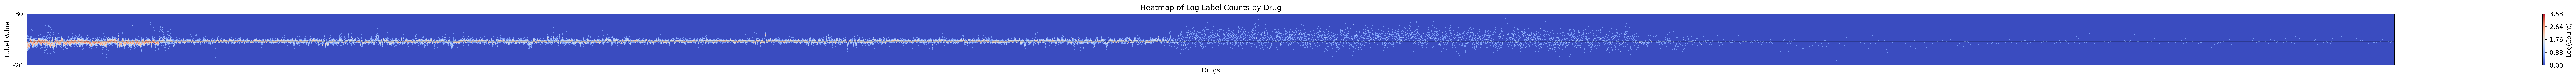

In [203]:
def create_custom_heatmap(heatmap_data):
    data = heatmap_data.T
    height, width = data.shape
    
    max_dimension = 65000  # slightly less than 2^16 to be safe(more than that I got the error that its too large)
    scale_factor = min(1, max_dimension / max(width, height))
    
    # Calculate the figure size with scaling
    figsize = (width * scale_factor / 100, height * scale_factor / 100)
    
    # Create afigure and axis with the calculated size
    fig, ax = plt.subplots(figsize=figsize, dpi=500)
    
    # Find the index of the zero bin
    zero_index = data.index.get_loc('0')
    
    # Create the heatmap
    cax = ax.imshow(data, aspect='auto', cmap='coolwarm', interpolation='nearest')
    
    # Set labels
    ax.set_xlabel('Drugs')
    ax.set_ylabel('Label Value')
    
    # Omit x-tick labels
    ax.set_xticks([])  # Remove x-ticks
    
    # Set y-ticks
    max_value = data.index.astype(float).max()
    min_value = data.index.astype(float).min()
    
    y_ticks = np.arange(min_value, max_value + 1, 20)
    ax.set_yticks(np.searchsorted(data.index.astype(float), y_ticks))
    ax.set_yticklabels([f'{int(tick)}' for tick in y_ticks])
    
    # Invert y-axis to have negative values at the bottom and positive at the top
    ax.invert_yaxis()
    
    # Add color bar with ticks
    cbar = fig.colorbar(cax, ax=ax, label='Log(Count)')
    cbar.set_ticks(np.linspace(data.min().min(), data.max().max(), num=5))
    cbar.set_ticklabels([f'{tick:.2f}' for tick in np.linspace(data.min().min(), data.max().max(), num=5)])
    
    # Add horizontal line at zero
    ax.axhline(y=zero_index, color='black', linewidth=0.5)
    
    plt.title('Heatmap of Log Label Counts by Drug')
    plt.tight_layout()
    
    # Instead of plt.show(), save the figure to a file
    plt.savefig(f'heatmap_synergy_{synergy_column}.png', dpi=500, bbox_inches='tight')
    fig.savefig(f'heatmap_synergy_{synergy_column}.svg', format='svg', dpi=500, bbox_inches='tight')
    fig.savefig(f'heatmap_synergy_{synergy_column}.pdf', format='pdf', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)  # Close the figure to free up memory

# Assuming heatmap_data is already created
create_custom_heatmap(heatmap_data)